Diana Covaci, 261 086 280

Nicholas Milin, 261 106 314

Viktor Allais, 261 148 866

In [59]:
!pip install -q numpy pandas matplotlib seaborn scikit-learn ucimlrepo
!pip install -q torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import itertools
from IPython.core.debugger import set_trace
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import copy



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\diana\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\diana\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Save and load model

In [33]:
# Utility functions for saving and loading models
import os
import pickle

def save_model(model, filename, directory='saved_models'):
    """Save a model to disk
    Args:
        model: The model to save
        filename: Name of the file (will add .pkl if not present)
        directory: Directory to save in (will be created if it doesn't exist)
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
    
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    filepath = os.path.join(directory, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filepath}")
    
def load_model(filename, directory='saved_models'):
    """Load a model from disk
    Args:
        filename: Name of the file (will add .pkl if not present)
        directory: Directory to load from
    Returns:
        The loaded model
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
        
    filepath = os.path.join(directory, filename)
    if not os.path.exists(filepath):
        print(f"No saved model found at {filepath}")
        return None
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {filepath}")
    return model

# Task 1: Acquire the data

In [24]:
# find mean & std for train_dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

loader_iter = iter(loader)
images, _ = next(loader_iter)
mean_train = images.mean().item()
std_train = images.std().item()
print((mean_train, std_train))

# normalize train_dataset & test_dataset
mlp_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
    transforms.Lambda(lambda x:x.view(-1))
])

full_train_dataset_normalized = datasets.FashionMNIST(root='./data', train=True, download=True, transform=mlp_transform)
test_dataset_normalized = datasets.FashionMNIST(root='./data', train=False, download=True, transform=mlp_transform)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_dataset_normalized))
val_size = len(full_train_dataset_normalized) - train_size

# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_normalized, val_dataset_normalized = random_split(full_train_dataset_normalized, [train_size, val_size], generator=generator)

# create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset_normalized, batch_size=batch_size, shuffle=True, generator=generator)
validation_loader = DataLoader(val_dataset_normalized, batch_size=batch_size, shuffle=False, generator=generator)
test_loader = DataLoader(test_dataset_normalized, batch_size=batch_size, shuffle=False, generator=generator)

# sanity check
x, y = next(iter(train_loader))
print((x.shape, y.shape)) # expect [64, 784] and [64]
input_size = x.shape[1]
output_size = len(set(full_train_dataset_normalized.targets.numpy()))
print(input_size, output_size)

(0.2860405743122101, 0.3530242443084717)
(torch.Size([64, 784]), torch.Size([64]))
784 10


# Task 2: Implement a Multilayer Perceptron

## Accuracy Score

In [4]:
def evaluate_acc(true, pred):
  return np.sum(true == pred) / len(true)

## Activation Functions

In [5]:
class relu:
  def activation(self, x):
    return np.maximum(0, x)
  def derivative(self, x):
    return np.where(x > 0, 1, 0)

class leakyRelu:
  def __init__(self, gamma=0.01):
    self.gamma = gamma
  def activation(self, x):
    return np.where(x > 0, x, self.gamma * x)
  def derivative(self, x):
    return np.where(x > 0, 1, self.gamma)

class sigmoid:
  def activation(self, x):
    return 1 / (1 + np.exp(-x))
  def derivative(self, x):
    return self.activation(x) * (1 - self.activation(x))

class tanh:
  def activation(self, x):
    return np.tanh(x)
  def derivative(self, x):
    return 1 - np.tanh(x) ** 2

class softmax:
  def activation(self, x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    total = np.sum(exp_x, axis=1, keepdims=True)
    return exp_x / total
  def derivative(self, x):
    return self.activation(x) * (1 - self.activation(x))


## MLP

In [86]:
def softmax(X):
  exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
  return exp_X / np.sum(exp_X, axis=1, keepdims=True)

# implementing the MLP class
class MLP:

  def __init__(self, activation_function, num_hidden_layers, units, seed=42):
    self.seed = seed
    self.activation_function = activation_function
    self.num_hidden_layers = num_hidden_layers
    self.units = units

    # initialize weights and biases
    self.layer_sizes = [input_size] + units + [output_size]
    self.L = num_hidden_layers + 1  # Number of layers (excluding input) (input is 0 indexed)
    self.weights = []
    self.biases = []
    self.activations = {}
    self.z_values = {}
    self.loss_history = []
    self.accuracy_history = []
    self.test_accuracy_history = []

    init_cache_name = f"init_{num_hidden_layers}_{'_'.join(map(str, units))}_{activation_function.__class__.__name__}"
    cached_init = load_model(init_cache_name)
    if cached_init is not None:
        self.weights = cached_init['weights']
        self.biases = cached_init['biases']
        self.layer_sizes = cached_init['layer_sizes']
    else:
      np.random.seed(self.seed)
      for i in range(len(self.layer_sizes)-1): 
        w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
        b = np.zeros((1, self.layer_sizes[i+1]))
        self.weights.append(w)
        self.biases.append(b)
      save_model({'weights': self.weights, 'biases': self.biases, 'layer_sizes': self.layer_sizes}, init_cache_name)

    self.grad_weights = {}
    self.grad_biases = {}

    self.lambda_l1 = 0
    self.lambda_l2 = 0

  def forward_propagation(self, X):
    # Forward propagation through the network
    self.activations[0] = X
    previous_activation = X
    # Hidden layers
    for l in range(self.L):
        W = self.weights[l]
        b = self.biases[l]

        Z = np.dot(previous_activation, W) + b
        # Activation for Layer L (last layer)
        if l == self.L - 1:
          A = softmax(Z)
        else:
          A = self.activation_function.activation(Z)

        self.z_values[l+1] = Z
        self.activations[l+1] = A
        previous_activation = A

    # Sums to 1 as it is softmax
    return previous_activation

  def backward_propagation(self, AL, X, Y):
    m = Y.shape[0]
    num_layers = self.L
    dZ = AL - Y

    for l in reversed(range(num_layers)):
      if l == 0:
        previous_activation = X
      else:
        previous_activation = self.activations[l]
      W = self.weights[l]

      self.grad_weights[l] = np.dot(previous_activation.T, dZ) / m
      self.grad_biases[l] = np.sum(dZ, axis=0, keepdims=True) / m

      # Add regularization gradients
      self.grad_weights[l] += (self.lambda_l1 * np.sign(W) + 2 * self.lambda_l2 * W) / m

      if l > 0:
        # Compute gradient for previous layer
        dA_prev = np.dot(dZ, W.T)
        Z_prev = self.z_values[l]
        dZ = dA_prev * self.activation_function.derivative(Z_prev)


  def update_parameters(self):
    for l in range(self.L):
      self.weights[l] -= self.learning_rate * self.grad_weights[l]
      self.biases[l] -= self.learning_rate * self.grad_biases[l]


  def compute_loss(self, AL, Y):
    """Compute cross-entropy loss"""
    m = Y.shape[0]

    # Clip probabilities to avoid log(0)
    epsilon = 1e-15
    AL = np.clip(AL, epsilon, 1 - epsilon)

    # Cross-entropy loss
    cross_entropy = -np.sum(Y * np.log(AL)) / m

    # L1 and L2 regularization terms
    l1_reg = self.lambda_l1 * sum(np.sum(np.abs(w)) for w in self.weights) / (2 * m)
    l2_reg = self.lambda_l2 * sum(np.sum(w**2) for w in self.weights) / (2 * m)

    total_loss = cross_entropy + l1_reg + l2_reg

    return total_loss
  
  def compute_accuracy(self, true, pred):
    predictions = np.argmax(pred, axis=1)
    labels = np.argmax(true, axis=1)
    accuracy = np.mean(predictions == labels)
    return accuracy


  def fit(self, train_loader, test_loader, learning_rate, epochs, lambda_l1=0.0, lambda_l2=0.0, retrain=False):
    trained_model_name = f"fit_{self.num_hidden_layers}_{'_'.join(map(str, self.units))}_{self.activation_function.__class__.__name__}_{learning_rate}_{epochs}_{lambda_l1}_{lambda_l2}"
    cached_trained = load_model(trained_model_name)
    if cached_trained is not None:
        self.weights = cached_trained['weights']
        self.biases = cached_trained['biases']
        self.layer_sizes = cached_trained['layer_sizes']
        self.loss_history = cached_trained['loss_history']
        self.accuracy_history = cached_trained['accuracy_history']
        self.test_accuracy_history = cached_trained['test_accuracy_history']
        if not retrain:
          print("Loaded trained model from cache.")
          for result in cached_trained['result_strings']:
            print(result)
          return
    self.accuracy_history = []
    self.loss_history = []
    self.test_accuracy_history = []

    np.random.seed(self.seed)
    self.lambda_l1 = lambda_l1
    self.lambda_l2 = lambda_l2
    self.learning_rate = learning_rate
    self.results = []
    for epoch in range(epochs):
      epoch_loss = 0
      n_batches = 0
      epoch_accuracy = 0

      for X_batch, y_batch in train_loader:
        X_batch_np = X_batch.numpy()
        y_batch_onehot = np.eye(output_size)[y_batch.numpy()] # One-hot encode labels

        # Forward propagation
        AL = self.forward_propagation(X_batch_np)

        # Compute loss and accuracy
        loss = self.compute_loss(AL, y_batch_onehot)
        accuracy = self.compute_accuracy(y_batch_onehot, AL)
        epoch_loss += loss
        epoch_accuracy += accuracy
        n_batches += 1

        # Backward propagation
        self.backward_propagation(AL, X_batch_np, y_batch_onehot)

        # Update parameters
        self.update_parameters()

      avg_loss = epoch_loss / n_batches
      avg_accuracy = epoch_accuracy / n_batches
      self.loss_history.append(avg_loss)
      self.accuracy_history.append(avg_accuracy)

      # Calculate test accuracy
      all_y_true_test = []
      all_y_pred_test = []
      for X_batch_test, y_batch_test in test_loader:
          X_batch_test_np = X_batch_test.numpy()
          y_batch_test_np = y_batch_test.numpy()
          y_pred_test = self.predict(X_batch_test_np)
          all_y_true_test.extend(y_batch_test_np)
          all_y_pred_test.extend(y_pred_test)
      test_accuracy = evaluate_acc(np.array(all_y_true_test), np.array(all_y_pred_test))
      self.test_accuracy_history.append(test_accuracy)
      result_string = f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}"
      self.results.append(result_string)
      print(result_string)
    
    save_model({'weights': self.weights,
                  'biases': self.biases,
                  'layer_sizes': self.layer_sizes,
                  'loss_history': self.loss_history,
                  'accuracy_history': self.accuracy_history,
                  'test_accuracy_history': self.test_accuracy_history, 
                  'result_strings': self.results},
                  trained_model_name)

  '''
  def fit(self, X, y, learning_rate, epochs):
    self.learning_rate = learning_rate
    for epoch in range(epochs):
      # Random permutation of indices
      np.random.seed(42+epoch)
      indices = np.random.permutation(N)
      X_shuffled = X[indices]
      y_shuffled = y[indices]

      epoch_loss = 0
      n_batches = 0
      epoch_accuracy = 0

      # Mini-batch gradient descent
      for i in range(0, n_samples, batch_size):
        # Get mini-batch
        end_idx = min(i + batch_size, n_samples)
        X_batch = X_shuffled[i:end_idx]
        y_batch = y_shuffled[i:end_idx]

        # Forward propagation
        AL = self.forward_propagation(X_batch)

        # Compute loss
        loss = self.compute_loss(AL, y_batch)
        accuracy = self.compute_accuracy(y_batch, AL)
        epoch_loss += loss
        epoch_accuracy += accuracy
        n_batches += 1

        # Backward propagation
        self.backward_propagation(AL, X_batch, y_batch)

        # Update parameters
        self.update_parameters()
    return self
'''
  def predict(self, X):
    """Make predictions"""
    AL = self.forward_propagation(X)
    predictions = np.argmax(AL, axis=1)
    return predictions

  def plot_history(self):
    """Plots the training loss and accuracy history."""
    epochs = range(1, len(self.loss_history) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, self.loss_history, 'bo-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, self.accuracy_history, 'ro-', label='Training Accuracy')
    plt.plot(epochs, self.test_accuracy_history, 'go-', label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Task 3: Run the experiments and report

In [7]:
# Example of how to save and load models

# Save a model (e.g., after training)
save_model(model3, 'model3_backup')  # Will save to saved_models/model3_backup.pkl

# Load a model (creates a completely independent copy)
model3_copy = load_model('model3_backup')  # Will load from saved_models/model3_backup.pkl
# model3_copy.fit(....)

NameError: name 'model3' is not defined

## 3.1: MLPs with Different depths

### Model 1: No hidden layers

Model loaded from saved_models\init_0__relu.pkl
Model loaded from saved_models\fit_0__relu_0.01_20_0.0_0.0.pkl
Loaded trained model from cache.
Epoch 1/20, Loss: 0.6770, Train Accuracy: 0.7663, Test Accuracy: 0.8023
Epoch 2/20, Loss: 0.5057, Train Accuracy: 0.8240, Test Accuracy: 0.8184
Epoch 3/20, Loss: 0.4745, Train Accuracy: 0.8352, Test Accuracy: 0.8227
Epoch 4/20, Loss: 0.4563, Train Accuracy: 0.8426, Test Accuracy: 0.8295
Epoch 5/20, Loss: 0.4451, Train Accuracy: 0.8445, Test Accuracy: 0.8336
Epoch 6/20, Loss: 0.4366, Train Accuracy: 0.8482, Test Accuracy: 0.8327
Epoch 7/20, Loss: 0.4303, Train Accuracy: 0.8495, Test Accuracy: 0.8332
Epoch 8/20, Loss: 0.4239, Train Accuracy: 0.8531, Test Accuracy: 0.8348
Epoch 9/20, Loss: 0.4203, Train Accuracy: 0.8543, Test Accuracy: 0.8356
Epoch 10/20, Loss: 0.4164, Train Accuracy: 0.8559, Test Accuracy: 0.8381
Epoch 11/20, Loss: 0.4131, Train Accuracy: 0.8574, Test Accuracy: 0.8397
Epoch 12/20, Loss: 0.4104, Train Accuracy: 0.8583, Test Accura

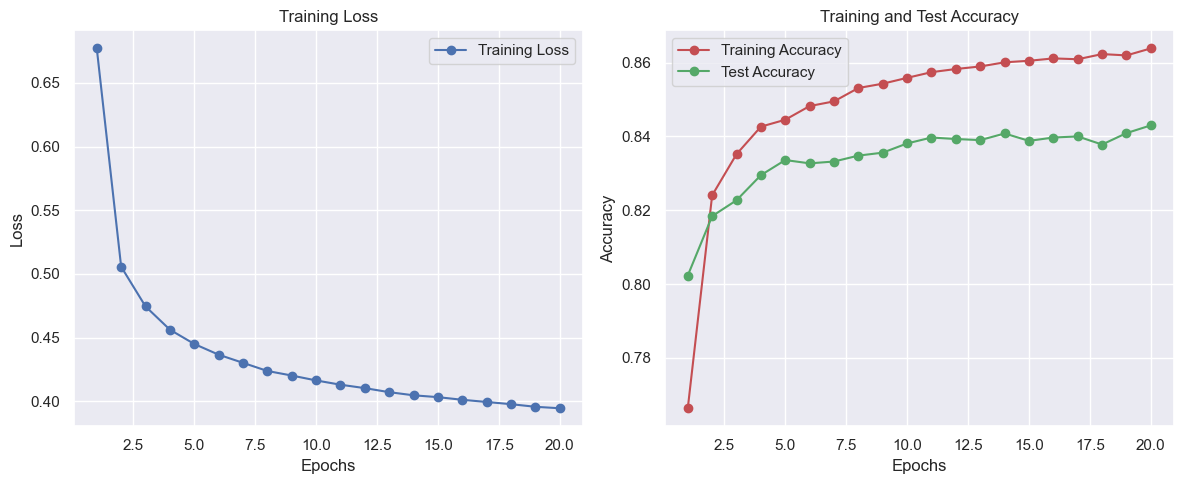

In [45]:
model1 = MLP(activation_function=relu(), num_hidden_layers=0, units=[])
model1.fit(train_loader, test_loader, 0.01, 20) 
model1.plot_history()

### Model 2: One hidden layers [256] ReLU

Model loaded from saved_models\init_1_256_relu.pkl
Model loaded from saved_models\fit_1_256_relu_0.01_20_0.0_0.0.pkl
Loaded trained model from cache.
Epoch 1/20, Loss: 0.6222, Train Accuracy: 0.7835, Test Accuracy: 0.8046
Epoch 2/20, Loss: 0.4544, Train Accuracy: 0.8395, Test Accuracy: 0.8332
Epoch 3/20, Loss: 0.4146, Train Accuracy: 0.8535, Test Accuracy: 0.8422
Epoch 4/20, Loss: 0.3899, Train Accuracy: 0.8618, Test Accuracy: 0.8477
Epoch 5/20, Loss: 0.3721, Train Accuracy: 0.8679, Test Accuracy: 0.8513
Epoch 6/20, Loss: 0.3575, Train Accuracy: 0.8734, Test Accuracy: 0.8539
Epoch 7/20, Loss: 0.3459, Train Accuracy: 0.8760, Test Accuracy: 0.8480
Epoch 8/20, Loss: 0.3366, Train Accuracy: 0.8795, Test Accuracy: 0.8550
Epoch 9/20, Loss: 0.3269, Train Accuracy: 0.8846, Test Accuracy: 0.8591
Epoch 10/20, Loss: 0.3188, Train Accuracy: 0.8859, Test Accuracy: 0.8595
Epoch 11/20, Loss: 0.3121, Train Accuracy: 0.8883, Test Accuracy: 0.8616
Epoch 12/20, Loss: 0.3058, Train Accuracy: 0.8909, Test 

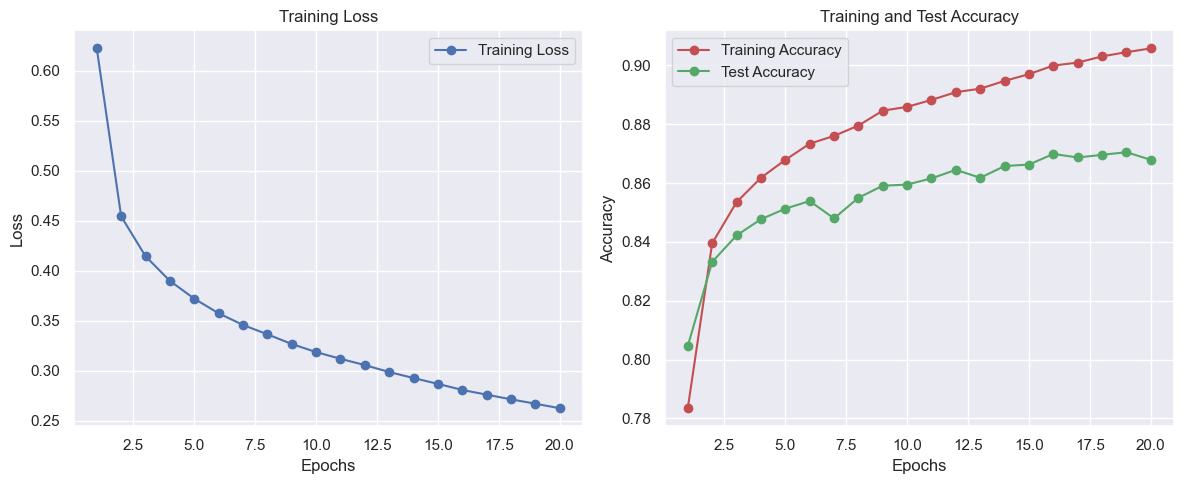

In [47]:
model2 = MLP(activation_function=relu(), num_hidden_layers=1, units=[256])
model2.fit(train_loader, test_loader, 0.01, 20)
model2.plot_history()

### Model 3: Two hidden layers [256,256] ReLU

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_20_0.0_0.0.pkl
Loaded trained model from cache.
Epoch 1/20, Loss: 0.6075, Train Accuracy: 0.7847, Test Accuracy: 0.8182
Epoch 2/20, Loss: 0.4298, Train Accuracy: 0.8448, Test Accuracy: 0.8387
Epoch 3/20, Loss: 0.3888, Train Accuracy: 0.8604, Test Accuracy: 0.8440
Epoch 4/20, Loss: 0.3629, Train Accuracy: 0.8675, Test Accuracy: 0.8500
Epoch 5/20, Loss: 0.3442, Train Accuracy: 0.8759, Test Accuracy: 0.8579
Epoch 6/20, Loss: 0.3290, Train Accuracy: 0.8814, Test Accuracy: 0.8566
Epoch 7/20, Loss: 0.3170, Train Accuracy: 0.8852, Test Accuracy: 0.8627
Epoch 8/20, Loss: 0.3053, Train Accuracy: 0.8885, Test Accuracy: 0.8603
Epoch 9/20, Loss: 0.2966, Train Accuracy: 0.8930, Test Accuracy: 0.8587
Epoch 10/20, Loss: 0.2870, Train Accuracy: 0.8953, Test Accuracy: 0.8654
Epoch 11/20, Loss: 0.2780, Train Accuracy: 0.8990, Test Accuracy: 0.8679
Epoch 12/20, Loss: 0.2706, Train Accuracy: 0.902

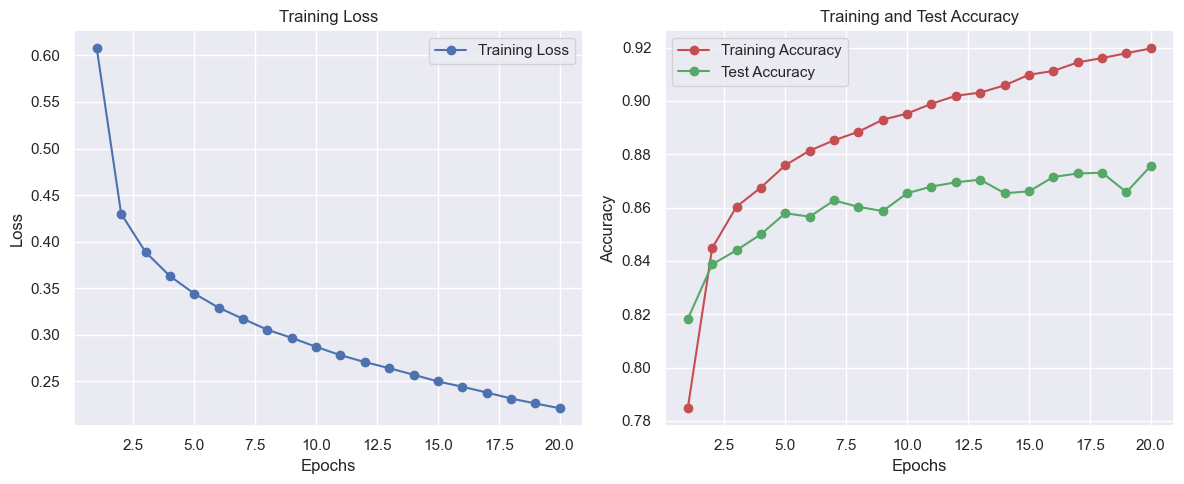

In [49]:
model3 = MLP(activation_function=relu(), num_hidden_layers=2, units=[256,256])
model3.fit(train_loader, test_loader, 0.01, 20)
model3.plot_history()

## 3.2: Activation Function Comparison

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_20_0.0_0.0.pkl
Loaded trained model from cache.
Epoch 1/20, Loss: 0.6075, Train Accuracy: 0.7847, Test Accuracy: 0.8182
Epoch 2/20, Loss: 0.4298, Train Accuracy: 0.8448, Test Accuracy: 0.8387
Epoch 3/20, Loss: 0.3888, Train Accuracy: 0.8604, Test Accuracy: 0.8440
Epoch 4/20, Loss: 0.3629, Train Accuracy: 0.8675, Test Accuracy: 0.8500
Epoch 5/20, Loss: 0.3442, Train Accuracy: 0.8759, Test Accuracy: 0.8579
Epoch 6/20, Loss: 0.3290, Train Accuracy: 0.8814, Test Accuracy: 0.8566
Epoch 7/20, Loss: 0.3170, Train Accuracy: 0.8852, Test Accuracy: 0.8627
Epoch 8/20, Loss: 0.3053, Train Accuracy: 0.8885, Test Accuracy: 0.8603
Epoch 9/20, Loss: 0.2966, Train Accuracy: 0.8930, Test Accuracy: 0.8587
Epoch 10/20, Loss: 0.2870, Train Accuracy: 0.8953, Test Accuracy: 0.8654
Epoch 11/20, Loss: 0.2780, Train Accuracy: 0.8990, Test Accuracy: 0.8679
Epoch 12/20, Loss: 0.2706, Train Accuracy: 0.902

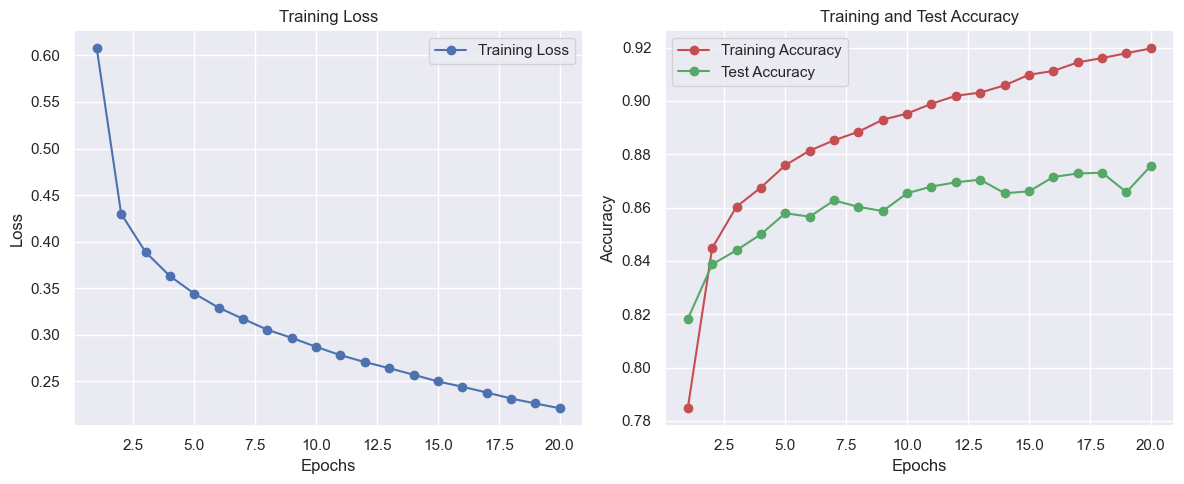

In [64]:
# Model with 2 hidden layers with ReLU activation function (from experiment 3.1)
model3_ReLU = MLP(activation_function=relu(), num_hidden_layers=2, units=[256,256])
model3_ReLU.fit(train_loader, test_loader, 0.01, 20)
model3_ReLU.plot_history()

Model loaded from saved_models\fit_2_256_256_tanh_0.01_20_0.0_0.0.pkl
Loaded trained model from cache.
Epoch 1/20, Loss: 0.3842, Train Accuracy: 0.8675, Test Accuracy: 0.8567
Epoch 2/20, Loss: 0.3049, Train Accuracy: 0.8936, Test Accuracy: 0.8644
Epoch 3/20, Loss: 0.2840, Train Accuracy: 0.9007, Test Accuracy: 0.8642
Epoch 4/20, Loss: 0.2698, Train Accuracy: 0.9047, Test Accuracy: 0.8675
Epoch 5/20, Loss: 0.2593, Train Accuracy: 0.9082, Test Accuracy: 0.8740
Epoch 6/20, Loss: 0.2505, Train Accuracy: 0.9123, Test Accuracy: 0.8711
Epoch 7/20, Loss: 0.2417, Train Accuracy: 0.9150, Test Accuracy: 0.8746
Epoch 8/20, Loss: 0.2357, Train Accuracy: 0.9164, Test Accuracy: 0.8758
Epoch 9/20, Loss: 0.2285, Train Accuracy: 0.9190, Test Accuracy: 0.8741
Epoch 10/20, Loss: 0.2231, Train Accuracy: 0.9219, Test Accuracy: 0.8768
Epoch 11/20, Loss: 0.2177, Train Accuracy: 0.9229, Test Accuracy: 0.8800
Epoch 12/20, Loss: 0.2120, Train Accuracy: 0.9256, Test Accuracy: 0.8803
Epoch 13/20, Loss: 0.2066, Tra

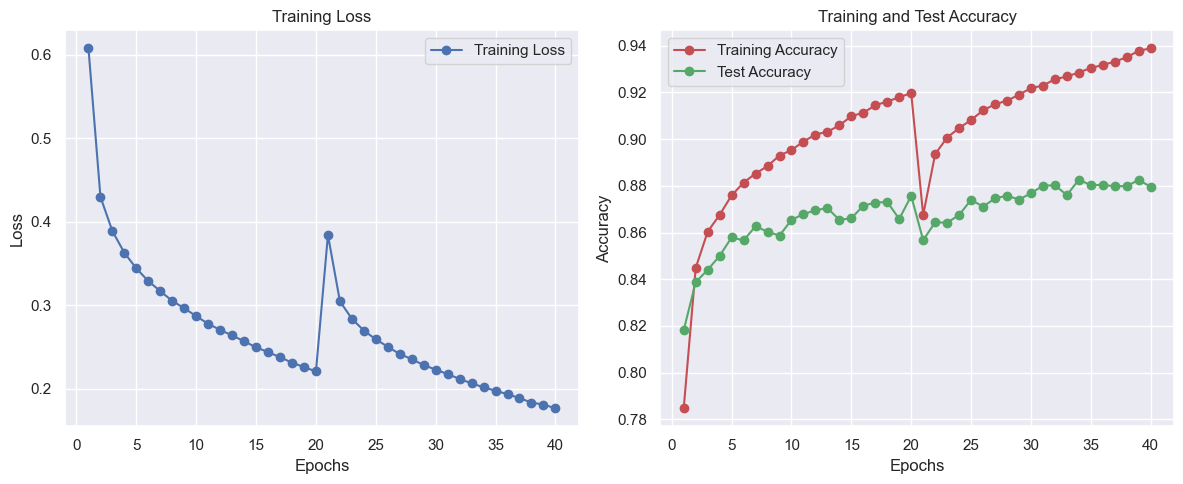

In [ ]:
# Copy of model with 2 hidden layers with tanh activation function
model3_tanh = copy.deepcopy(model3_ReLU)
model3_tanh.activation_function = tanh()
model3_tanh.fit(train_loader, test_loader, 0.01, 20)
model3_tanh.plot_history()

No saved model found at saved_models\fit_2_256_256_leakyRelu_0.01_20_0.0_0.0.pkl
Epoch 1/20, Loss: 0.2162, Train Accuracy: 0.9224, Test Accuracy: 0.8761
Epoch 2/20, Loss: 0.2104, Train Accuracy: 0.9248, Test Accuracy: 0.8735
Epoch 3/20, Loss: 0.2058, Train Accuracy: 0.9266, Test Accuracy: 0.8722
Epoch 4/20, Loss: 0.2007, Train Accuracy: 0.9284, Test Accuracy: 0.8712
Epoch 5/20, Loss: 0.1963, Train Accuracy: 0.9297, Test Accuracy: 0.8777
Epoch 6/20, Loss: 0.1939, Train Accuracy: 0.9304, Test Accuracy: 0.8733
Epoch 7/20, Loss: 0.1885, Train Accuracy: 0.9318, Test Accuracy: 0.8791
Epoch 8/20, Loss: 0.1834, Train Accuracy: 0.9341, Test Accuracy: 0.8775
Epoch 9/20, Loss: 0.1794, Train Accuracy: 0.9360, Test Accuracy: 0.8733
Epoch 10/20, Loss: 0.1753, Train Accuracy: 0.9384, Test Accuracy: 0.8782
Epoch 11/20, Loss: 0.1716, Train Accuracy: 0.9393, Test Accuracy: 0.8761
Epoch 12/20, Loss: 0.1665, Train Accuracy: 0.9414, Test Accuracy: 0.8821
Epoch 13/20, Loss: 0.1626, Train Accuracy: 0.9425, T

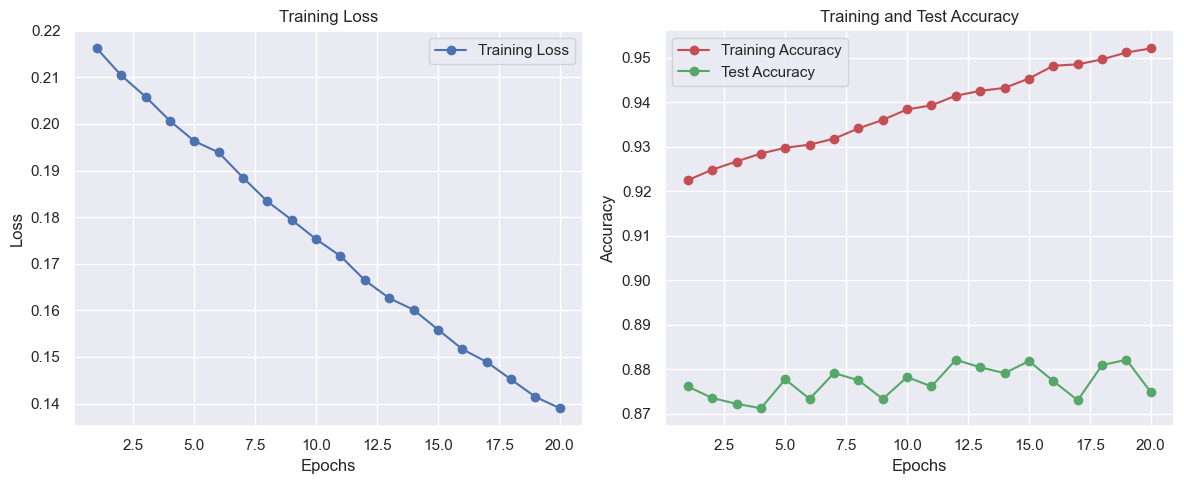

In [81]:
# Copy of model with 2 hidden layers with leaky ReLU activation function
model3_leakyReLU = copy.deepcopy(model3_ReLU)
model3_leakyReLU.activation_function = leakyRelu()
model3_leakyReLU.fit(train_loader, test_loader, 0.01, 20)
model3_leakyReLU.plot_history()

In [ ]:
# ???
#model3_40epochs = copy.deepcopy(model3)
#model3_40epochs.fit(train_loader, test_loader, 0.01, 20)
#model3_40epochs.plot_history()

Epoch 1/20, Loss: 0.2111, Train Accuracy: 0.9249, Test Accuracy: 0.8787
Epoch 2/20, Loss: 0.2067, Train Accuracy: 0.9267, Test Accuracy: 0.8801
Epoch 3/20, Loss: 0.2012, Train Accuracy: 0.9289, Test Accuracy: 0.8804
Epoch 4/20, Loss: 0.1966, Train Accuracy: 0.9309, Test Accuracy: 0.8811
Epoch 5/20, Loss: 0.1916, Train Accuracy: 0.9334, Test Accuracy: 0.8833
Epoch 6/20, Loss: 0.1873, Train Accuracy: 0.9333, Test Accuracy: 0.8823
Epoch 7/20, Loss: 0.1826, Train Accuracy: 0.9358, Test Accuracy: 0.8828
Epoch 8/20, Loss: 0.1788, Train Accuracy: 0.9369, Test Accuracy: 0.8786
Epoch 9/20, Loss: 0.1745, Train Accuracy: 0.9391, Test Accuracy: 0.8785
Epoch 10/20, Loss: 0.1693, Train Accuracy: 0.9405, Test Accuracy: 0.8814
Epoch 11/20, Loss: 0.1668, Train Accuracy: 0.9422, Test Accuracy: 0.8819
Epoch 12/20, Loss: 0.1620, Train Accuracy: 0.9440, Test Accuracy: 0.8846
Epoch 13/20, Loss: 0.1582, Train Accuracy: 0.9464, Test Accuracy: 0.8808
Epoch 14/20, Loss: 0.1541, Train Accuracy: 0.9475, Test Accu

## 3.3: L1 and L2 Regularization

In [83]:
lambda_ranges = np.concatenate((np.array([0]), np.logspace(-4, 0, 5)))

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.0_0.0.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 0.6074, Train Accuracy: 0.7855, Test Accuracy: 0.8208
Epoch 2/10, Loss: 0.4294, Train Accuracy: 0.8441, Test Accuracy: 0.8417
Epoch 3/10, Loss: 0.3872, Train Accuracy: 0.8601, Test Accuracy: 0.8401
Epoch 4/10, Loss: 0.3633, Train Accuracy: 0.8683, Test Accuracy: 0.8479
Epoch 5/10, Loss: 0.3441, Train Accuracy: 0.8751, Test Accuracy: 0.8554
Epoch 6/10, Loss: 0.3283, Train Accuracy: 0.8801, Test Accuracy: 0.8569
Epoch 7/10, Loss: 0.3159, Train Accuracy: 0.8847, Test Accuracy: 0.8637
Epoch 8/10, Loss: 0.3047, Train Accuracy: 0.8887, Test Accuracy: 0.8642
Epoch 9/10, Loss: 0.2951, Train Accuracy: 0.8931, Test Accuracy: 0.8618
Epoch 10/10, Loss: 0.2858, Train Accuracy: 0.8969, Test Accuracy: 0.8654


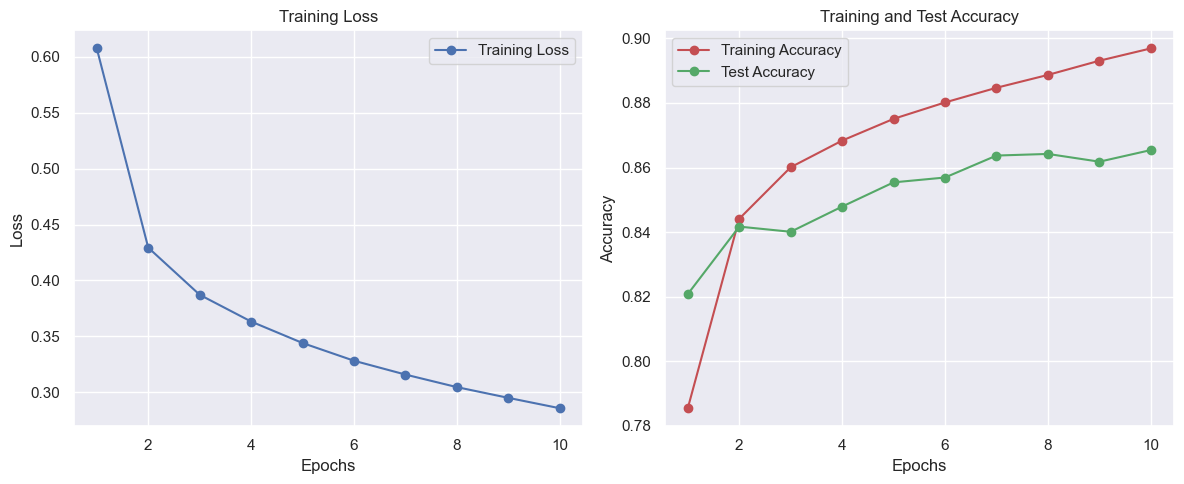

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.0001_0.0.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 0.6174, Train Accuracy: 0.7856, Test Accuracy: 0.8208
Epoch 2/10, Loss: 0.4387, Train Accuracy: 0.8456, Test Accuracy: 0.8378
Epoch 3/10, Loss: 0.3971, Train Accuracy: 0.8602, Test Accuracy: 0.8493
Epoch 4/10, Loss: 0.3731, Train Accuracy: 0.8683, Test Accuracy: 0.8460
Epoch 5/10, Loss: 0.3542, Train Accuracy: 0.8762, Test Accuracy: 0.8528
Epoch 6/10, Loss: 0.3396, Train Accuracy: 0.8820, Test Accuracy: 0.8550
Epoch 7/10, Loss: 0.3265, Train Accuracy: 0.8860, Test Accuracy: 0.8624
Epoch 8/10, Loss: 0.3153, Train Accuracy: 0.8885, Test Accuracy: 0.8590
Epoch 9/10, Loss: 0.3054, Train Accuracy: 0.8928, Test Accuracy: 0.8668
Epoch 10/10, Loss: 0.2961, Train Accuracy: 0.8958, Test Accuracy: 0.8676


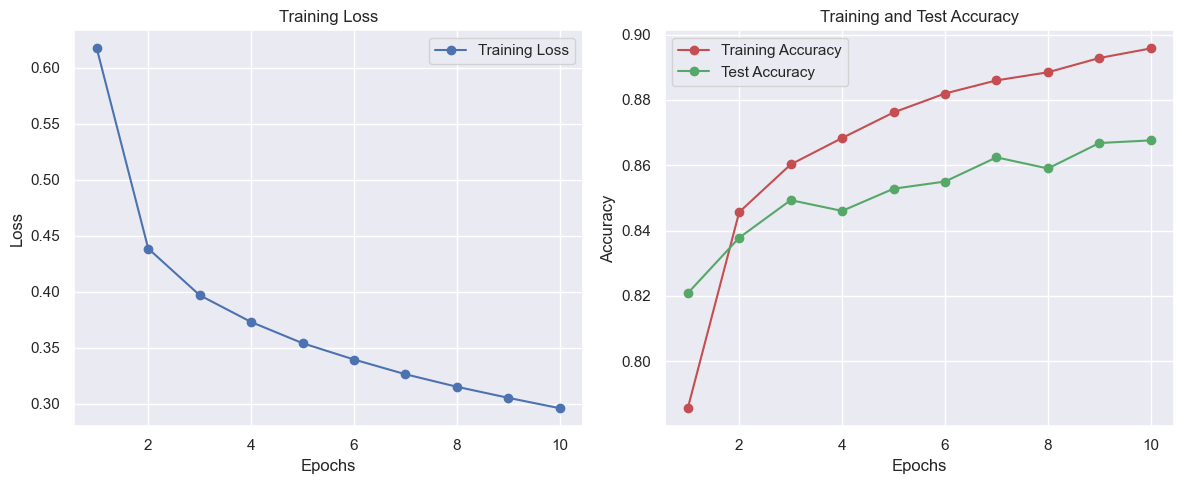

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.001_0.0.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 0.7097, Train Accuracy: 0.7854, Test Accuracy: 0.8158
Epoch 2/10, Loss: 0.5304, Train Accuracy: 0.8449, Test Accuracy: 0.8352
Epoch 3/10, Loss: 0.4895, Train Accuracy: 0.8590, Test Accuracy: 0.8476
Epoch 4/10, Loss: 0.4637, Train Accuracy: 0.8683, Test Accuracy: 0.8522
Epoch 5/10, Loss: 0.4456, Train Accuracy: 0.8742, Test Accuracy: 0.8573
Epoch 6/10, Loss: 0.4306, Train Accuracy: 0.8786, Test Accuracy: 0.8577
Epoch 7/10, Loss: 0.4179, Train Accuracy: 0.8858, Test Accuracy: 0.8613
Epoch 8/10, Loss: 0.4068, Train Accuracy: 0.8880, Test Accuracy: 0.8607
Epoch 9/10, Loss: 0.3970, Train Accuracy: 0.8927, Test Accuracy: 0.8675
Epoch 10/10, Loss: 0.3879, Train Accuracy: 0.8954, Test Accuracy: 0.8687


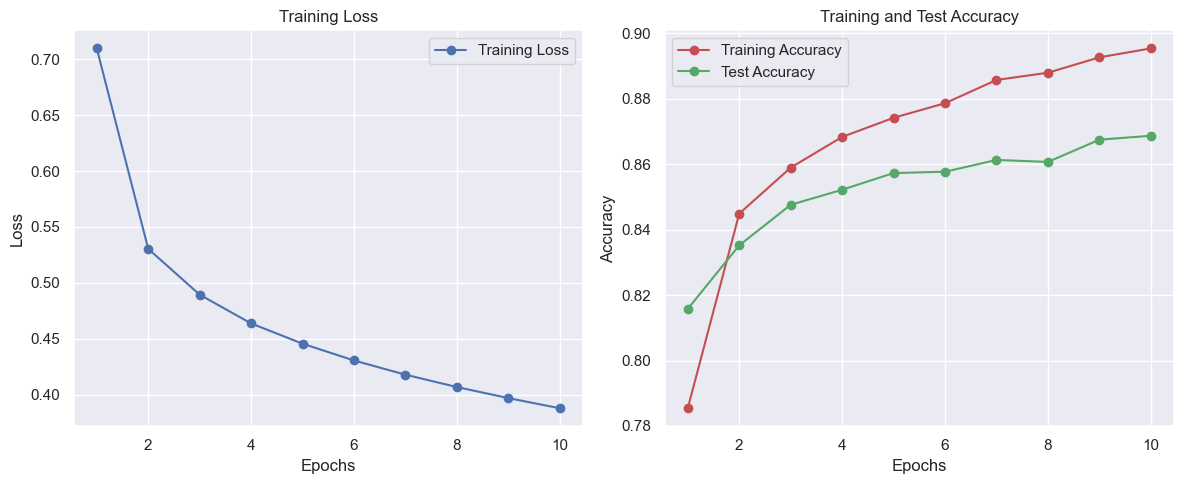

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.01_0.0.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 1.6061, Train Accuracy: 0.7836, Test Accuracy: 0.8056
Epoch 2/10, Loss: 1.4048, Train Accuracy: 0.8444, Test Accuracy: 0.8320
Epoch 3/10, Loss: 1.3415, Train Accuracy: 0.8599, Test Accuracy: 0.8494
Epoch 4/10, Loss: 1.2947, Train Accuracy: 0.8688, Test Accuracy: 0.8523
Epoch 5/10, Loss: 1.2564, Train Accuracy: 0.8750, Test Accuracy: 0.8542
Epoch 6/10, Loss: 1.2232, Train Accuracy: 0.8780, Test Accuracy: 0.8483
Epoch 7/10, Loss: 1.1916, Train Accuracy: 0.8815, Test Accuracy: 0.8561
Epoch 8/10, Loss: 1.1604, Train Accuracy: 0.8869, Test Accuracy: 0.8612
Epoch 9/10, Loss: 1.1334, Train Accuracy: 0.8888, Test Accuracy: 0.8639
Epoch 10/10, Loss: 1.1075, Train Accuracy: 0.8922, Test Accuracy: 0.8677


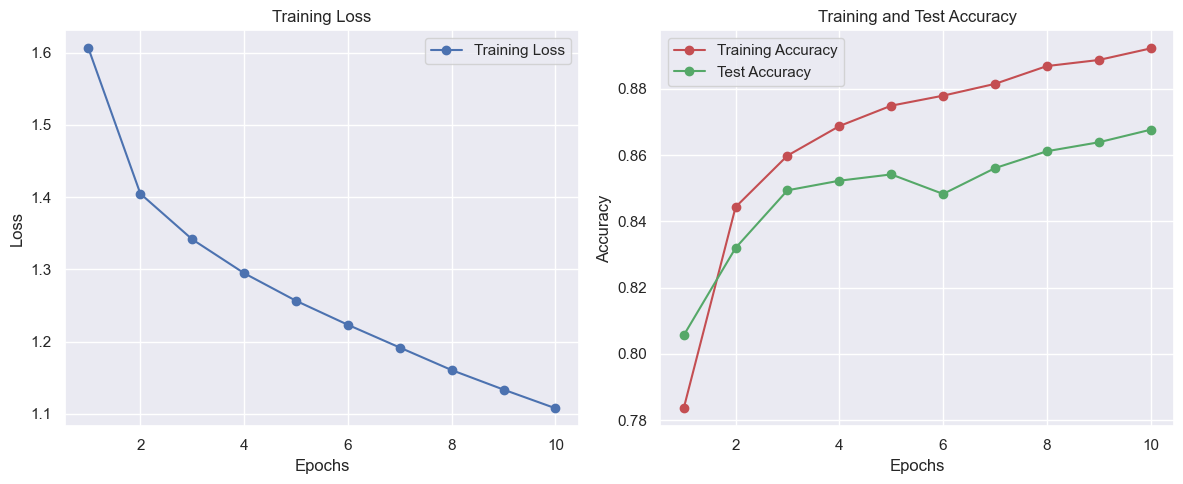

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.1_0.0.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 9.5476, Train Accuracy: 0.7827, Test Accuracy: 0.8176
Epoch 2/10, Loss: 7.3628, Train Accuracy: 0.8366, Test Accuracy: 0.8307
Epoch 3/10, Loss: 5.7074, Train Accuracy: 0.8445, Test Accuracy: 0.8294
Epoch 4/10, Loss: 4.4207, Train Accuracy: 0.8462, Test Accuracy: 0.8349
Epoch 5/10, Loss: 3.4481, Train Accuracy: 0.8437, Test Accuracy: 0.8271
Epoch 6/10, Loss: 2.7338, Train Accuracy: 0.8391, Test Accuracy: 0.8299
Epoch 7/10, Loss: 2.2180, Train Accuracy: 0.8357, Test Accuracy: 0.8140
Epoch 8/10, Loss: 1.8464, Train Accuracy: 0.8318, Test Accuracy: 0.8196
Epoch 9/10, Loss: 1.5727, Train Accuracy: 0.8289, Test Accuracy: 0.8211
Epoch 10/10, Loss: 1.3650, Train Accuracy: 0.8287, Test Accuracy: 0.8145


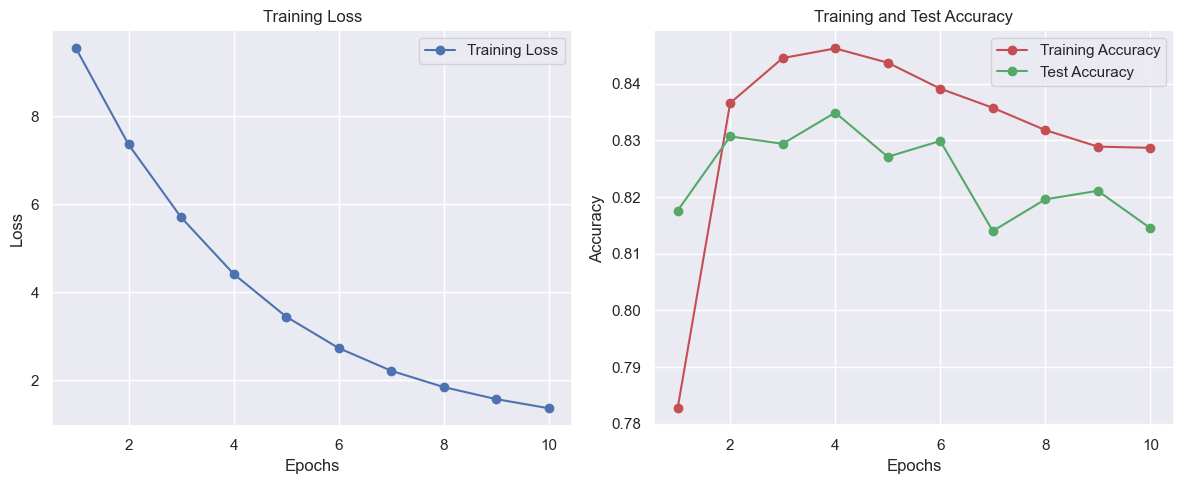

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_1.0_0.0.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 35.2770, Train Accuracy: 0.7088, Test Accuracy: 0.5999
Epoch 2/10, Loss: 3.8022, Train Accuracy: 0.3884, Test Accuracy: 0.4606
Epoch 3/10, Loss: 1.7711, Train Accuracy: 0.5377, Test Accuracy: 0.5703
Epoch 4/10, Loss: 1.5258, Train Accuracy: 0.5942, Test Accuracy: 0.6141
Epoch 5/10, Loss: 1.4500, Train Accuracy: 0.6210, Test Accuracy: 0.6459
Epoch 6/10, Loss: 1.4092, Train Accuracy: 0.6388, Test Accuracy: 0.6493
Epoch 7/10, Loss: 1.3764, Train Accuracy: 0.6561, Test Accuracy: 0.6787
Epoch 8/10, Loss: 1.3389, Train Accuracy: 0.6791, Test Accuracy: 0.6844
Epoch 9/10, Loss: 1.3127, Train Accuracy: 0.6921, Test Accuracy: 0.7007
Epoch 10/10, Loss: 1.2951, Train Accuracy: 0.6990, Test Accuracy: 0.7046


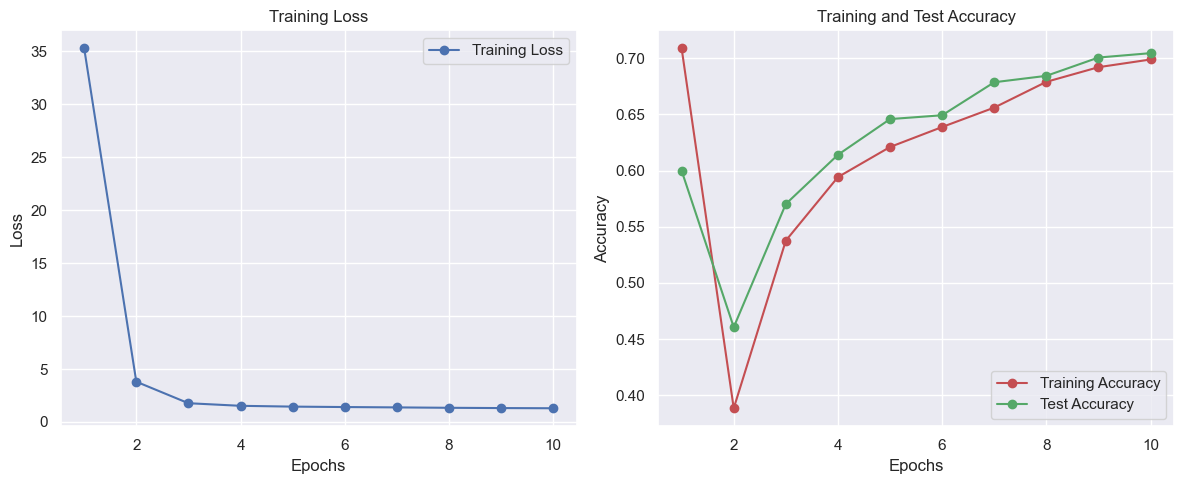

In [88]:
for l in lambda_ranges:
    model = MLP(activation_function=relu(), num_hidden_layers=2, units=[256,256])
    model.fit(train_loader, test_loader, 0.01, 10, lambda_l1=l)
    model.plot_history()

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.0_0.0.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 0.6074, Train Accuracy: 0.7855, Test Accuracy: 0.8208
Epoch 2/10, Loss: 0.4294, Train Accuracy: 0.8441, Test Accuracy: 0.8417
Epoch 3/10, Loss: 0.3872, Train Accuracy: 0.8601, Test Accuracy: 0.8401
Epoch 4/10, Loss: 0.3633, Train Accuracy: 0.8683, Test Accuracy: 0.8479
Epoch 5/10, Loss: 0.3441, Train Accuracy: 0.8751, Test Accuracy: 0.8554
Epoch 6/10, Loss: 0.3283, Train Accuracy: 0.8801, Test Accuracy: 0.8569
Epoch 7/10, Loss: 0.3159, Train Accuracy: 0.8847, Test Accuracy: 0.8637
Epoch 8/10, Loss: 0.3047, Train Accuracy: 0.8887, Test Accuracy: 0.8642
Epoch 9/10, Loss: 0.2951, Train Accuracy: 0.8931, Test Accuracy: 0.8618
Epoch 10/10, Loss: 0.2858, Train Accuracy: 0.8969, Test Accuracy: 0.8654


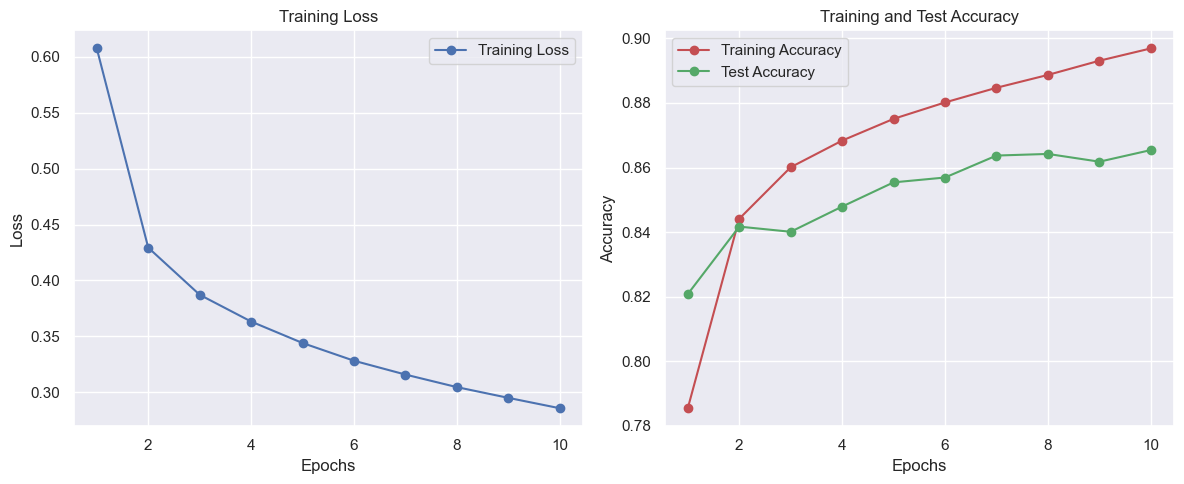

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.0_0.0001.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 0.6079, Train Accuracy: 0.7862, Test Accuracy: 0.8225
Epoch 2/10, Loss: 0.4304, Train Accuracy: 0.8453, Test Accuracy: 0.8398
Epoch 3/10, Loss: 0.3881, Train Accuracy: 0.8600, Test Accuracy: 0.8466
Epoch 4/10, Loss: 0.3643, Train Accuracy: 0.8673, Test Accuracy: 0.8489
Epoch 5/10, Loss: 0.3448, Train Accuracy: 0.8750, Test Accuracy: 0.8545
Epoch 6/10, Loss: 0.3310, Train Accuracy: 0.8817, Test Accuracy: 0.8545
Epoch 7/10, Loss: 0.3167, Train Accuracy: 0.8854, Test Accuracy: 0.8608
Epoch 8/10, Loss: 0.3054, Train Accuracy: 0.8888, Test Accuracy: 0.8553
Epoch 9/10, Loss: 0.2962, Train Accuracy: 0.8924, Test Accuracy: 0.8657
Epoch 10/10, Loss: 0.2865, Train Accuracy: 0.8960, Test Accuracy: 0.8658


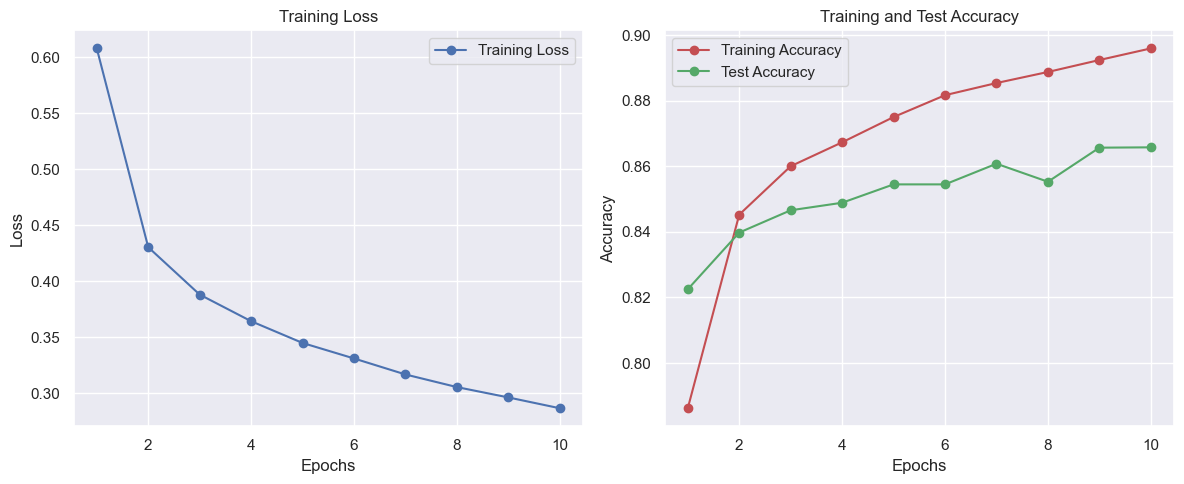

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.0_0.001.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 0.6151, Train Accuracy: 0.7846, Test Accuracy: 0.8221
Epoch 2/10, Loss: 0.4382, Train Accuracy: 0.8450, Test Accuracy: 0.8393
Epoch 3/10, Loss: 0.3951, Train Accuracy: 0.8600, Test Accuracy: 0.8438
Epoch 4/10, Loss: 0.3707, Train Accuracy: 0.8692, Test Accuracy: 0.8549
Epoch 5/10, Loss: 0.3526, Train Accuracy: 0.8755, Test Accuracy: 0.8534
Epoch 6/10, Loss: 0.3375, Train Accuracy: 0.8806, Test Accuracy: 0.8582
Epoch 7/10, Loss: 0.3251, Train Accuracy: 0.8840, Test Accuracy: 0.8629
Epoch 8/10, Loss: 0.3143, Train Accuracy: 0.8874, Test Accuracy: 0.8623
Epoch 9/10, Loss: 0.3035, Train Accuracy: 0.8932, Test Accuracy: 0.8610
Epoch 10/10, Loss: 0.2947, Train Accuracy: 0.8958, Test Accuracy: 0.8667


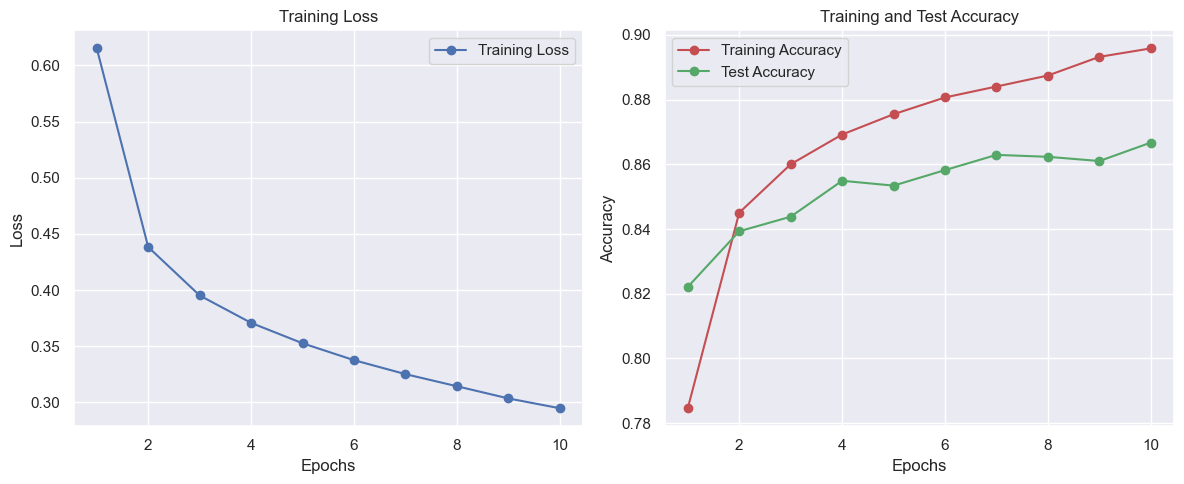

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.0_0.01.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 0.6919, Train Accuracy: 0.7839, Test Accuracy: 0.8158
Epoch 2/10, Loss: 0.5131, Train Accuracy: 0.8440, Test Accuracy: 0.8360
Epoch 3/10, Loss: 0.4701, Train Accuracy: 0.8595, Test Accuracy: 0.8392
Epoch 4/10, Loss: 0.4450, Train Accuracy: 0.8680, Test Accuracy: 0.8546
Epoch 5/10, Loss: 0.4261, Train Accuracy: 0.8739, Test Accuracy: 0.8564
Epoch 6/10, Loss: 0.4112, Train Accuracy: 0.8808, Test Accuracy: 0.8593
Epoch 7/10, Loss: 0.3978, Train Accuracy: 0.8858, Test Accuracy: 0.8604
Epoch 8/10, Loss: 0.3862, Train Accuracy: 0.8888, Test Accuracy: 0.8637
Epoch 9/10, Loss: 0.3772, Train Accuracy: 0.8919, Test Accuracy: 0.8662
Epoch 10/10, Loss: 0.3683, Train Accuracy: 0.8953, Test Accuracy: 0.8653


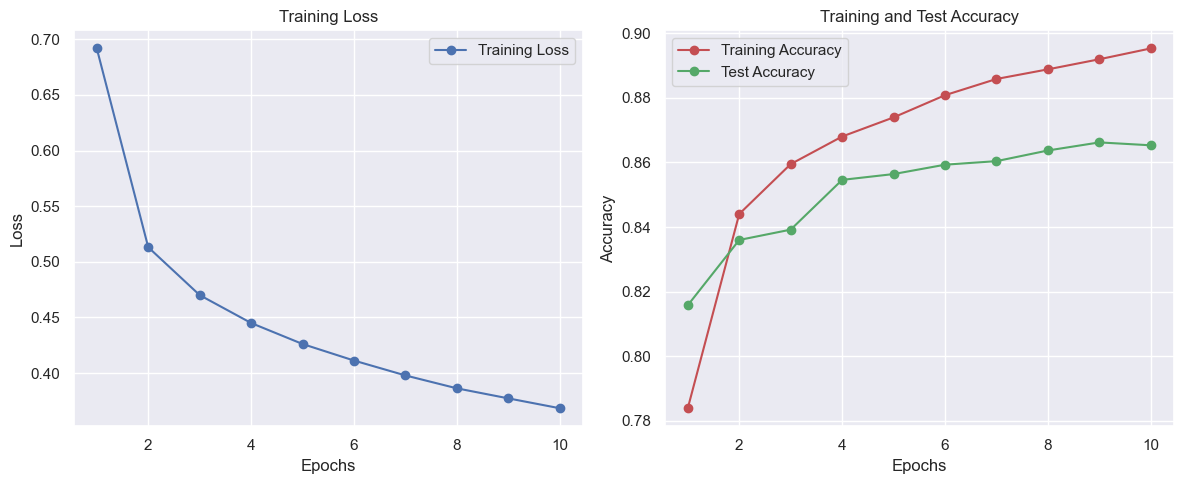

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.0_0.1.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 1.4091, Train Accuracy: 0.7869, Test Accuracy: 0.8131
Epoch 2/10, Loss: 1.1976, Train Accuracy: 0.8438, Test Accuracy: 0.8374
Epoch 3/10, Loss: 1.1256, Train Accuracy: 0.8584, Test Accuracy: 0.8499
Epoch 4/10, Loss: 1.0707, Train Accuracy: 0.8667, Test Accuracy: 0.8497
Epoch 5/10, Loss: 1.0241, Train Accuracy: 0.8723, Test Accuracy: 0.8531
Epoch 6/10, Loss: 0.9838, Train Accuracy: 0.8778, Test Accuracy: 0.8554
Epoch 7/10, Loss: 0.9457, Train Accuracy: 0.8819, Test Accuracy: 0.8614
Epoch 8/10, Loss: 0.9116, Train Accuracy: 0.8846, Test Accuracy: 0.8591
Epoch 9/10, Loss: 0.8790, Train Accuracy: 0.8874, Test Accuracy: 0.8636
Epoch 10/10, Loss: 0.8494, Train Accuracy: 0.8904, Test Accuracy: 0.8637


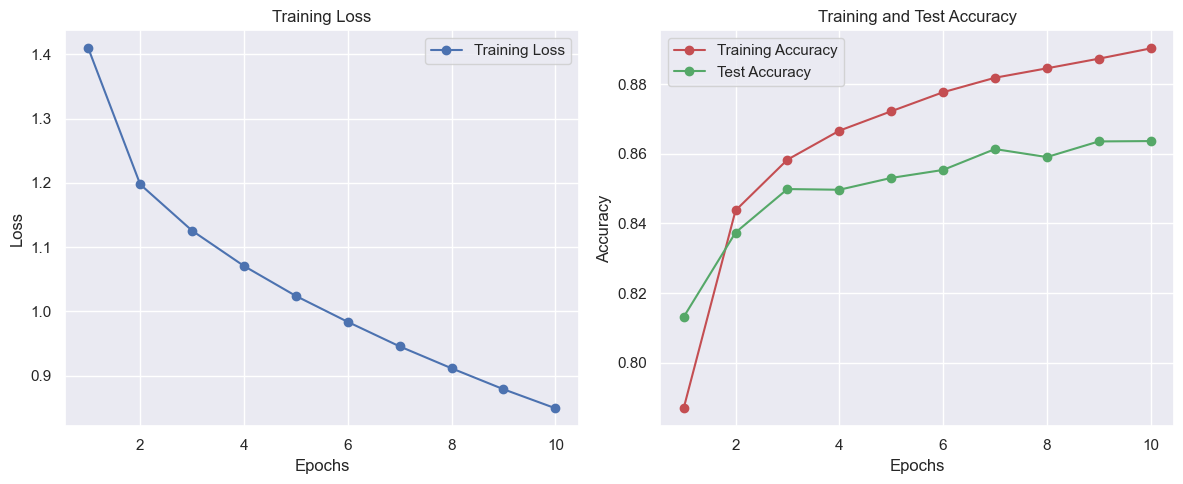

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.0_1.0.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 7.1646, Train Accuracy: 0.7820, Test Accuracy: 0.8082
Epoch 2/10, Loss: 4.6225, Train Accuracy: 0.8328, Test Accuracy: 0.8290
Epoch 3/10, Loss: 3.1138, Train Accuracy: 0.8409, Test Accuracy: 0.8209
Epoch 4/10, Loss: 2.1797, Train Accuracy: 0.8430, Test Accuracy: 0.8294
Epoch 5/10, Loss: 1.6004, Train Accuracy: 0.8423, Test Accuracy: 0.8290
Epoch 6/10, Loss: 1.2403, Train Accuracy: 0.8410, Test Accuracy: 0.8313
Epoch 7/10, Loss: 1.0147, Train Accuracy: 0.8418, Test Accuracy: 0.8267
Epoch 8/10, Loss: 0.8743, Train Accuracy: 0.8411, Test Accuracy: 0.8288
Epoch 9/10, Loss: 0.7854, Train Accuracy: 0.8413, Test Accuracy: 0.8293
Epoch 10/10, Loss: 0.7300, Train Accuracy: 0.8401, Test Accuracy: 0.8257


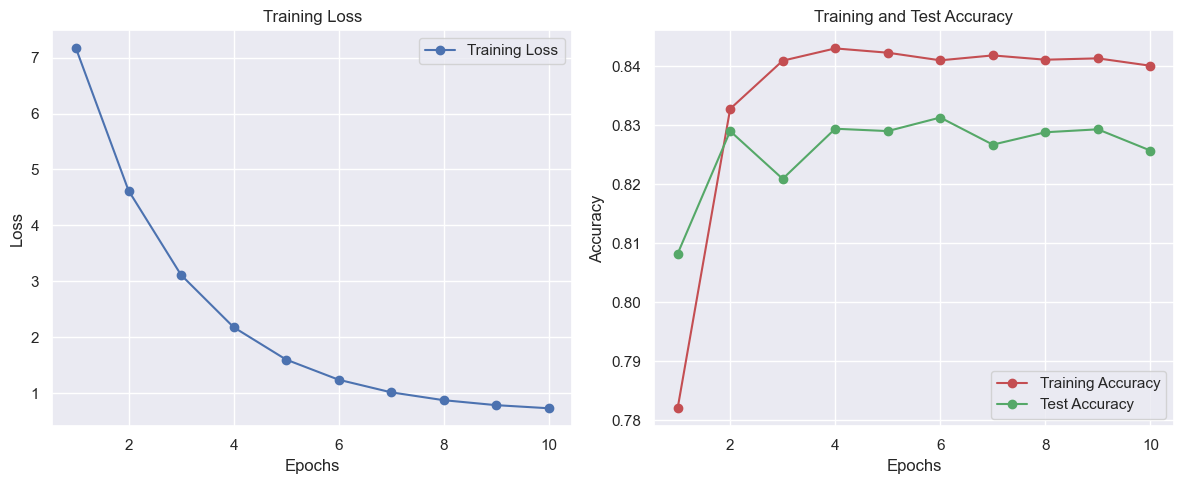

In [90]:
for l in lambda_ranges:
    model = MLP(activation_function=relu(), num_hidden_layers=2, units=[256,256])
    model.fit(train_loader, test_loader, 0.01, 10, lambda_l2=l)
    model.plot_history()

## 3.6: CNN Using Pytorch

In [7]:
# Device (use GPU if available but don't change MLP behavior)
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
if device == "cpu":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

Using device: mps


In [10]:
# Create CNN-specific transforms
cnn_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

full_train_cnn = datasets.FashionMNIST(root='./data', train=True, download=True, transform=cnn_transform)
test_dataset_cnn = datasets.FashionMNIST(root='./data', train=False, download=True, transform=cnn_transform)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_cnn))
val_size = len(full_train_cnn) - train_size

# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_cnn, val_dataset_cnn = random_split(full_train_cnn, [train_size, val_size])

# create dataloaders
batch_size = 64
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False)

# sanity check
x_cnn, y_cnn = next(iter(train_loader_cnn))
print((x_cnn.shape, y_cnn.shape)) # expect [64, 1, 28, 28] and [64]

(torch.Size([64, 1, 28, 28]), torch.Size([64]))
